# Customer Churn Prediction

In this project we will be trying to predict customer churn by analyzing customer data and building machine learning models to predict which customers are likely to churn. We will preprocess the data and perform EDA to gain some insight into the overall dataset. We will perform feature engineering to create new features to enhance the quality of the models. We will split our data in to 3 sets via a 60/20/20 split for training, validation, and testing sets. We will then proceed to train atleast two models, one logistic regression to use a baseline, and atleast one boosting model, which we hope with perform better. We will tune hyperparameters via cross validation grids and refine our models until we acheive an AUC-ROC score > 88%, at which point we will use our best performing model on the final test data and submit a final report with our results and findings. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


In [2]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
display(contract_df.head())
print(contract_df.isnull().sum())
print(contract_df['customerID'].duplicated().sum())

display(personal_df.head())
print(personal_df.isnull().sum())
print(personal_df['customerID'].duplicated().sum())

display(internet_df.head())
print(internet_df.isnull().sum())
print(internet_df['customerID'].duplicated().sum())

display(phone_df.head())
print(phone_df.isnull().sum())
print(phone_df['customerID'].duplicated().sum())



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


customerID       0
MultipleLines    0
dtype: int64
0


We can see there is no null values or duplicated values in any of our datasets which is great, but there is some obvious issues with the data that need to be addressed. First, to facilitate processing, we will merge the datasets using left join. Then we will convert the column names to lowercase and snake case to avoid confusion later. 

In [4]:
df = contract_df.merge(personal_df, on='customerID', how='left')

df = df.merge(internet_df, on='customerID', how='left')

df = df.merge(phone_df, on='customerID', how='left')


In [5]:
display(df.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [6]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)  
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name) 
    return name.lower()

df.columns = [to_snake_case(col) for col in df.columns]

Here we will check the dataset to confirm the column names have been converted properly. 

In [7]:
display(df.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Here we will encode binary features as well as multi class features and create a new "Churn" column using the values from end date column which will have binary value for yes/no churn. 

In [8]:
binary_map = {
    'Yes': 1,
    'No': 0,
    'Female': 0,
    'Male': 1
}

binary_cols = [
    'paperless_billing', 'partner', 'dependents', 'gender',
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'
]

df[binary_cols] = df[binary_cols].replace(binary_map)


In [9]:
multi_class_cols = ['payment_method', 'internet_service', 'type']

df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)


In [10]:
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [11]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [12]:
display(df.head(10))

,customer_id,begin_date,end_date,paperless_billing,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,...,streaming_tv,streaming_movies,multiple_lines,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,type_One year,type_Two year,churn
0,7590-VHVEG,2020-01-01,NaT,1,29.85,29.85,0,0,1,0,...,0.0,0.0,NaN,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,NaT,0,56.95,1889.50,1,0,0,0,...,0.0,0.0,0.0,0,0,1,0,1,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,1,53.85,108.15,1,0,0,0,...,0.0,0.0,0.0,0,0,1,0,0,0,1
3,7795-CFOCW,2016-05-01,NaT,0,42.30,1840.75,1,0,0,0,...,0.0,0.0,NaN,0,0,0,0,1,0,0
4,9237-HQITU,2019-09-01,2019-11-01,1,70.70,151.65,0,0,0,0,...,0.0,0.0,0.0,0,1,0,1,0,0,1
5,9305-CDSKC,2019-03-01,2019-11-01,1,99.65,820.50,0,0,0,0,...,1.0,1.0,1.0,0,1,0,1,0,0,1
6,1452-KIOVK,2018-04-01,NaT,1,89.10,1949.40,1,0,0,1,...,1.0,0.0,1.0,1,0,0,1,0,0,0
7,6713-OKOMC,2019-04-01,NaT,0,29.75,301.90,0,0,0,0,...,0.0,0.0,NaN,0,0,1,0,0,0,0
8,7892-POOKP,2017-07-01,2019-11-01,1,104.80,3046.05,0,0,1,0,...,1.0,1.0,1.0,0,1,0,1,0,0,1
9,6388-TABGU,2014-12-01,NaT,0,56.15,3487.95,1,0,0,1,...,0.0,0.0,0.0,0,0,0,0,1,0,0


Now we will perform more detailed EDA to get a better idea of our data and try to derive some basic insights before moving on to model training. 

In [13]:
df.info()
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   customer_id                             7043 non-null   object        
 1   begin_date                              7043 non-null   datetime64[ns]
 2   end_date                                1869 non-null   datetime64[ns]
 3   paperless_billing                       7043 non-null   int64         
 4   monthly_charges                         7043 non-null   float64       
 5   total_charges                           7032 non-null   float64       
 6   gender                                  7043 non-null   int64         
 7   senior_citizen                          7043 non-null   int64         
 8   partner                                 7043 non-null   int64         
 9   dependents                              7043 non-nul

,paperless_billing,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,...,streaming_tv,streaming_movies,multiple_lines,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,type_One year,type_Two year,churn
count,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,...,5517.000000,5517.000000,6361.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2283.300441,0.504756,0.162147,0.483033,0.299588,0.365960,0.440276,0.439007,...,0.490665,0.495197,0.467065,0.216101,0.335794,0.228880,0.439585,0.209144,0.240664,0.265370
std,0.491457,30.090047,2266.771362,0.500013,0.368612,0.499748,0.458110,0.481742,0.496465,0.496311,...,0.499958,0.500022,0.498953,0.411613,0.472301,0.420141,0.496372,0.406726,0.427517,0.441561
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1397.475000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3794.737500,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0.7346301292063041

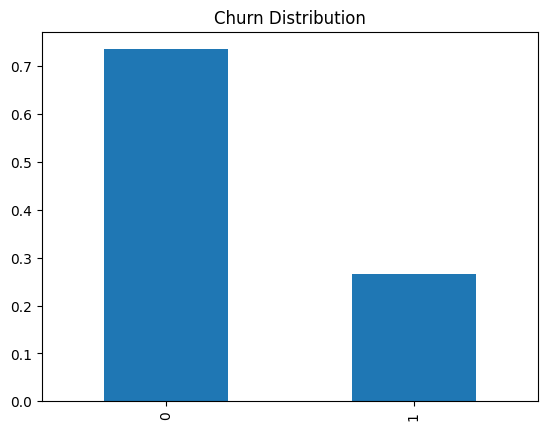

In [14]:
df['churn'].value_counts(normalize=True).plot(kind='bar', title='Churn Distribution')

len(contract_df[contract_df['EndDate'] == 'No']) / len(contract_df)


We can see about 27% of customers churned

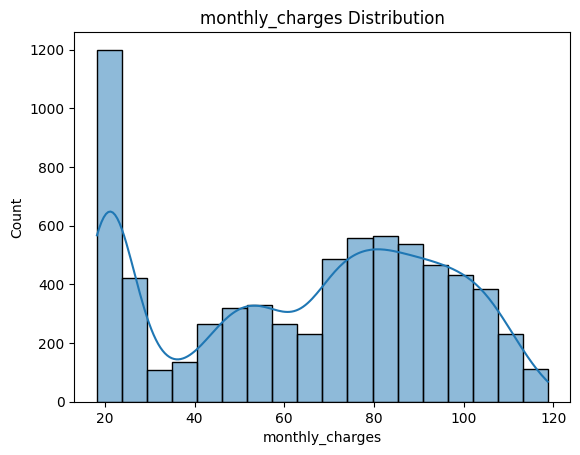

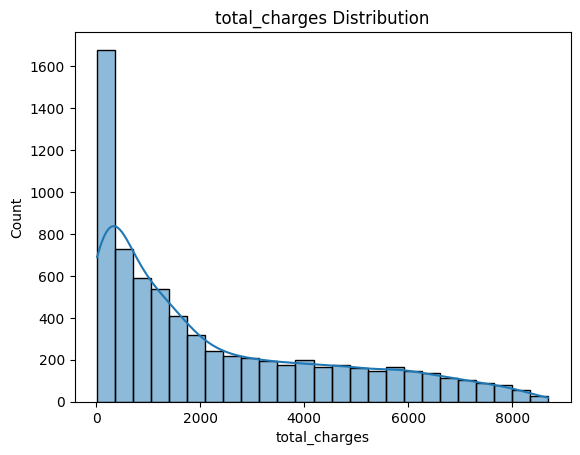

In [15]:
num_cols = ['monthly_charges', 'total_charges']

for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')

We can see from the charts that majority of customers have lower cost plans, with count of users highest at the bottom end, then increasing slightly until about the $80 range and decreasing again. 

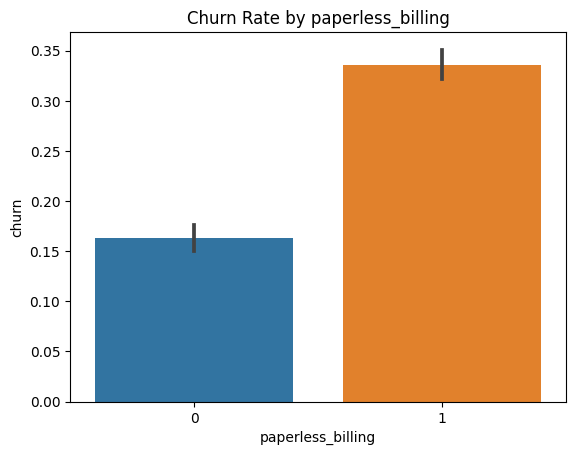

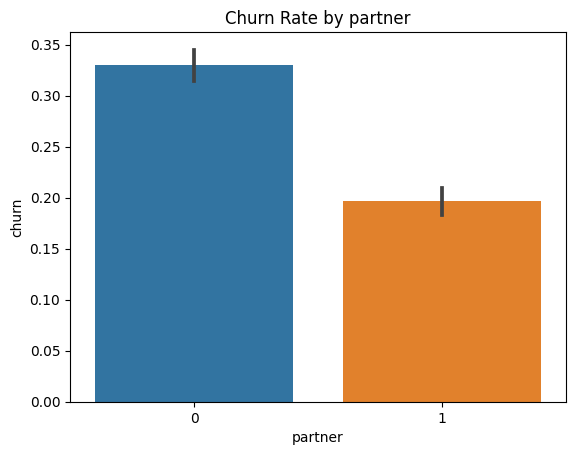

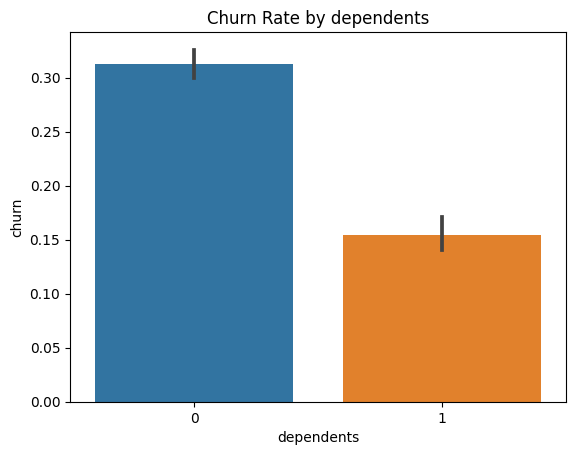

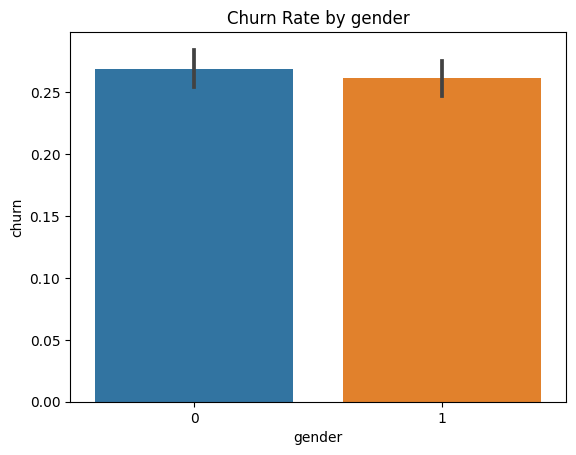

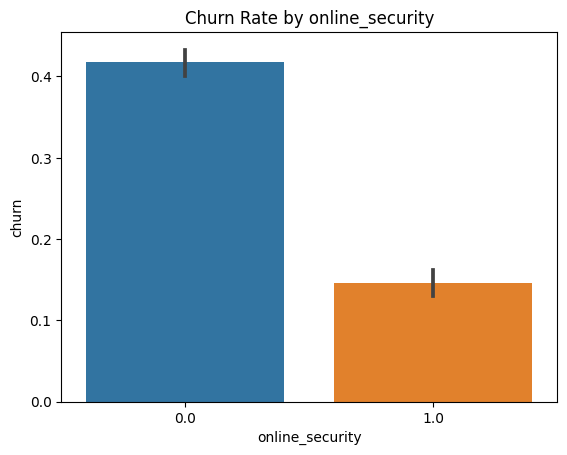

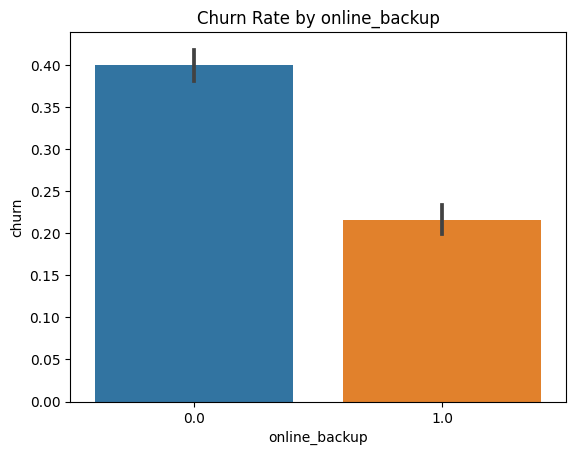

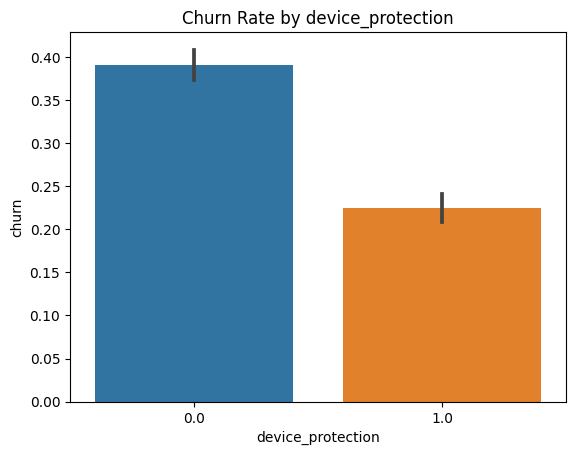

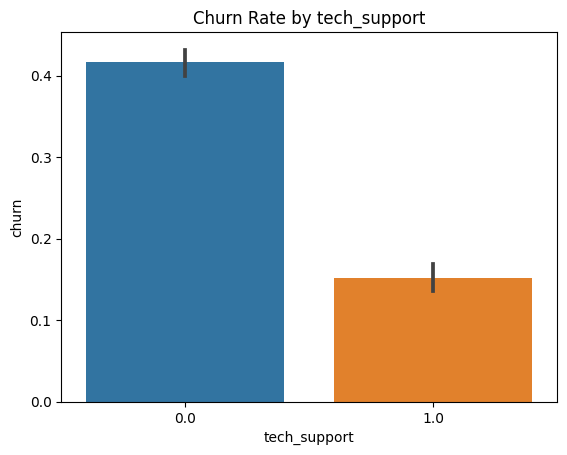

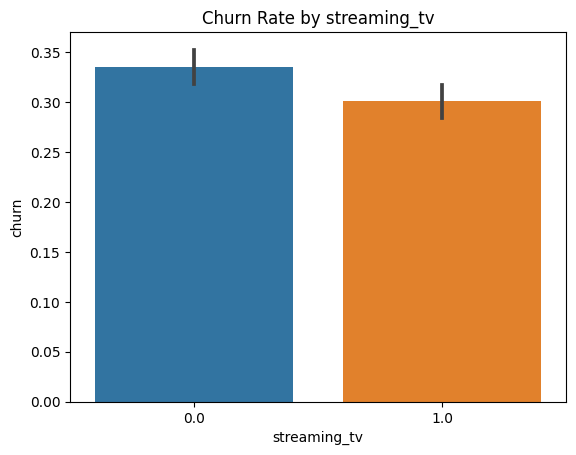

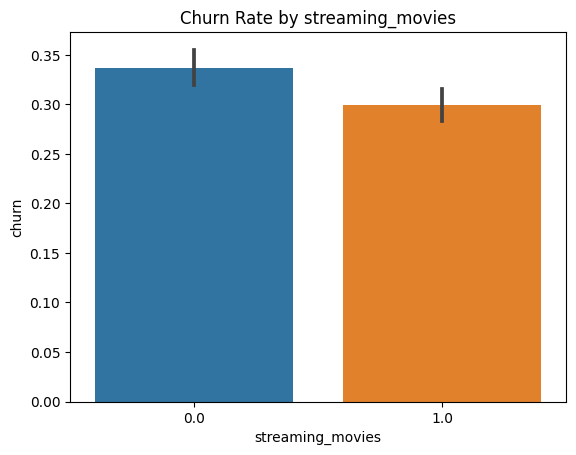

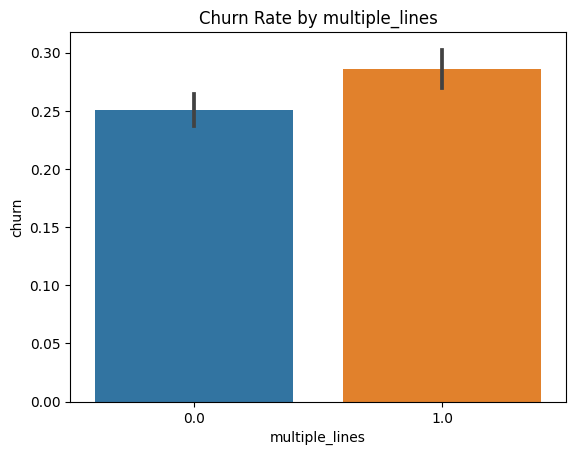

In [16]:
cat_cols = [
    'paperless_billing', 'partner', 'dependents', 'gender',
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'
]

for col in cat_cols:
    plt.figure()
    sns.barplot(x=col, y='churn', data=df)
    plt.title(f'Churn Rate by {col}')


Here we can see there is a strong connection of churn rate with paperless billing, tech support, and online security. 

Text(0.5, 1.0, 'Correlation Heatmap')

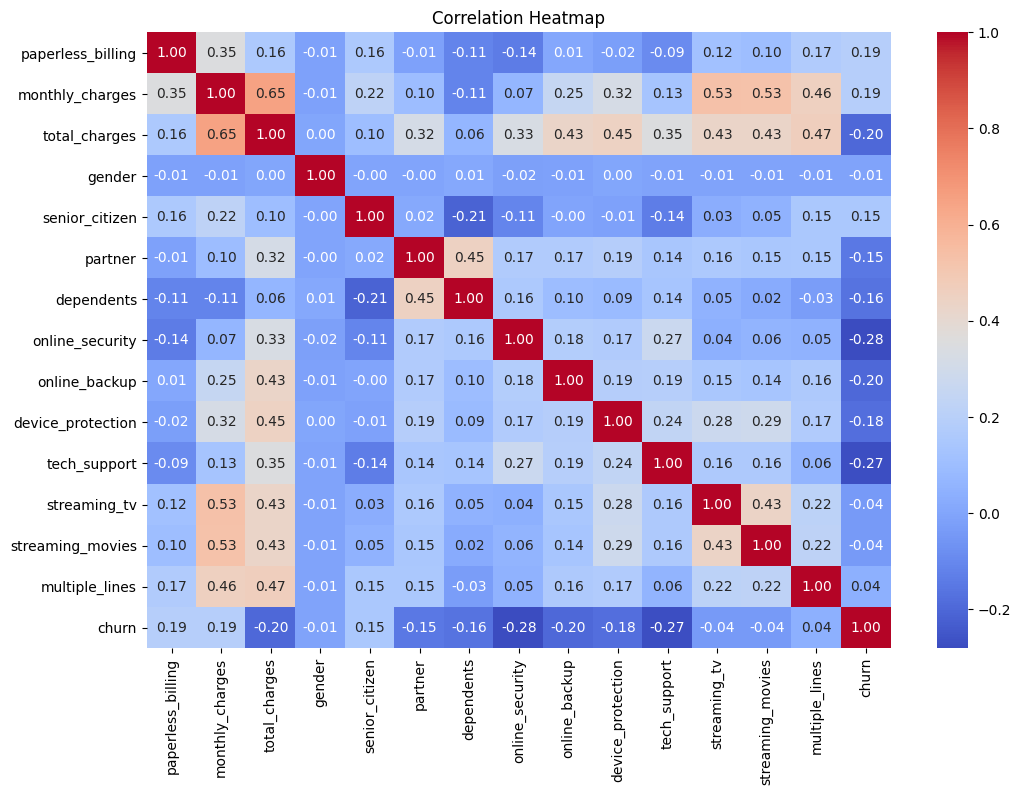

In [17]:
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64']) 
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')


Here we will look for relationships between churn and date. We will check if there is higher chrun on specific months or if there is a correlation between begindate months and churn. 

In [18]:
today = pd.Timestamp('2020-02-01')
df['tenure_days'] = (df['end_date'].fillna(today) - df['begin_date']).dt.days

df['churn_month'] = df['end_date'].dt.month

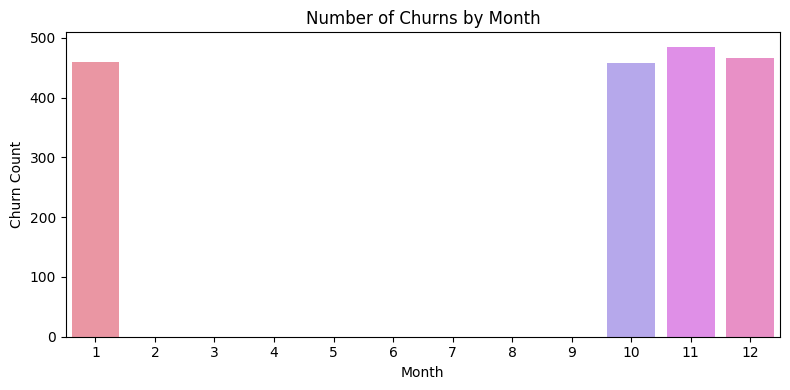

In [19]:
all_months = pd.Index(range(1, 13), name='churn_month')

churn_by_month = (
    df[df['end_date'].notna()]
    .groupby('churn_month')
    .size()
    .reindex(all_months, fill_value=0)
)

plt.figure(figsize=(8, 4))
sns.barplot(x=churn_by_month.index, y=churn_by_month.values)
plt.title("Number of Churns by Month")
plt.xlabel("Month")
plt.ylabel("Churn Count")
plt.tight_layout()
plt.show()



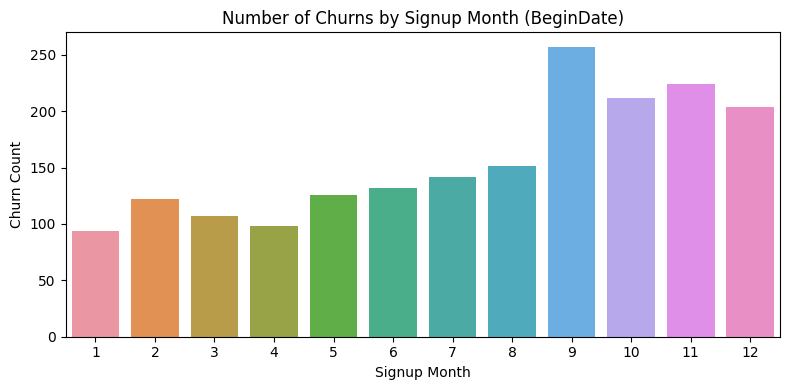

In [20]:
df['signup_month'] = pd.to_datetime(df['begin_date'], errors='coerce').dt.month

signup_churn = (
    df[df['churn'] == 1]
    .groupby('signup_month')
    .size()
    .reindex(range(1, 13), fill_value=0) 
)

plt.figure(figsize=(8, 4))
sns.barplot(x=signup_churn.index, y=signup_churn.values)
plt.title("Number of Churns by Signup Month (BeginDate)")
plt.xlabel("Signup Month")
plt.ylabel("Churn Count")
plt.tight_layout()
plt.show()


We can see there is indeed a correlation between begindate (signup month) and churn, with higher churn in customers who sign up in the winter months. We will use this for feature enginering so we can include the signup month as a feature in our models. We will use only begindate and not end date as that would lead to data leakage, considering any customer with an end date would obviously have a positive value for "churn", defeating the purpose of our model. 

In [21]:
df['signup_month'] = pd.to_datetime(df['begin_date'], errors='coerce').dt.month

Now we will begin training our models. First we will train a simple Logistic Regression model to use as a baseline and split the data into 60/20/20 for trianing, validation, and final testing. We will encode the feature variables to facilitate the processing. Moving forward we will try atleast one boosting model to see if we can improve the results. 

In [22]:
drop_cols = ['customer_id', 'begin_date', 'end_date', 'churn_month']
X = df.drop(columns=drop_cols + ['churn'])
y = df['churn']

service_cols = [
    'tech_support', 'online_security', 'online_backup',
    'device_protection', 'streaming_tv', 'streaming_movies', 'multiple_lines'
]
X[service_cols] = X[service_cols].fillna('No')

X['total_charges'] = X['total_charges'].fillna(X['total_charges'].median())

X = pd.get_dummies(X, drop_first=True)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)


In [23]:
X.dtypes[X.dtypes == 'object']
X.isnull().sum().sort_values(ascending=False).head()


paperless_billing       0
online_security_1.0     0
multiple_lines_1.0      0
streaming_movies_No     0
streaming_movies_1.0    0
dtype: int64

Validation Results:
[[932 103]
 [177 197]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

AUC-ROC Score: 0.8376


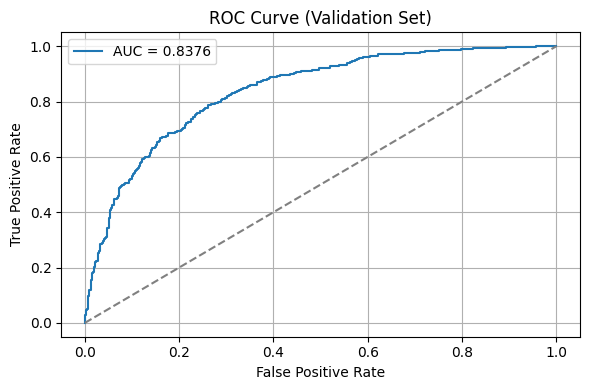

In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1] 

print("Validation Results:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_val_proba):.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Regression model is performing quite well already, now we will attempt to further improve the results by training more advanced models. 

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Validation Results (Tuned XGBoost - Fast):
[[1008   27]
 [ 116  258]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1035
           1       0.91      0.69      0.78       374

    accuracy                           0.90      1409
   macro avg       0.90      0.83      0.86      1409
weighted avg       0.90      0.90      0.89      1409

AUC-ROC Score: 0.9417


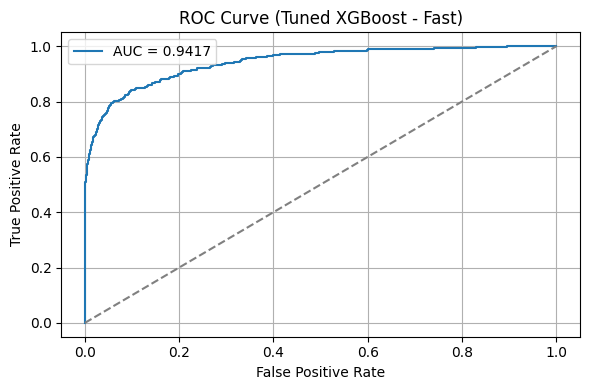

In [25]:
param_dist = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100],
    'scale_pos_weight': [1, 2]
}

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=6,         
    scoring='roc_auc',
    cv=2,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("Validation Results (Tuned XGBoost - Fast):")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_val_proba):.4f}")

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned XGBoost - Fast)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here we achieved excellent results, with an AUC-ROC score of 94%! We used an XG Boost model which achieves very strong predictive power by building ensembles of decision trees and correcting mistakes of previous generations. We selected hyperparameters for a good balance of efficiency and performance, and made sure to include scale_pos_weight to balance the classes, since we had many more non-churners in the data than churners. We used cross validation to select the best overall combination. 

Test Results (Final XGBoost Model):
[[1011   24]
 [ 111  263]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1035
           1       0.92      0.70      0.80       374

    accuracy                           0.90      1409
   macro avg       0.91      0.84      0.87      1409
weighted avg       0.91      0.90      0.90      1409

AUC–ROC Score (Test Set): 0.9486


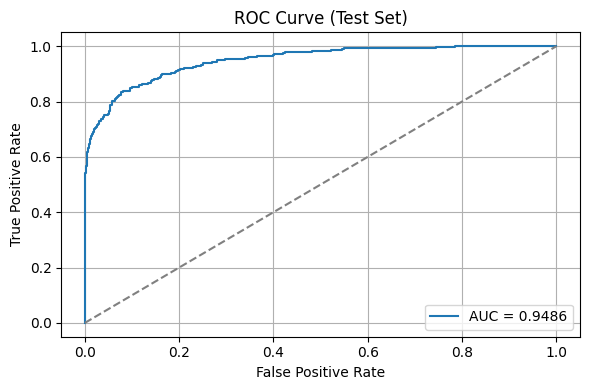

In [26]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Results (Final XGBoost Model):")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(f"AUC–ROC Score (Test Set): {roc_auc_score(y_test, y_test_proba):.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Here we achieve a final test AUC-ROC score of 94% ! 

# Conclusion 

Over the course of our analysis we gained some important insights into our data. We found that our hunch was correct and there was in fact a correlation between begin/end dates and churn. We found that customers who signed up during winter months were far more likely to churn, and that churns mostly happen in the winter months as well. We then used this information in our feature engineering to improve the performance of our models. For the model training we started with a simple logistic regression as a baseline and then moved on to a more advanced XG Boost model. We selected hyperparameters that would be efficient enough to complete in reasonable time while providing the best possible performance, and used a CV grid to select the best combination of parameters. We made sure to balance the classes in our final model and achieved an excellent AUC-ROC score of 94% ! Overall, we found our model accurately predicted churn in users. 